# Accuracy & Performance of Pitch Detection Algorithms

This notebook analyses results from testing 3 popular pitch detection algorithms:
- **Yin** algorithm
- Average Magnitude Difference Function (**AMDF**)
- Fast Fourier Transform (**FFT**)

### Dataset:
The algorithms were ran on [Tensorflow Nsynth dataset](https://magenta.tensorflow.org/datasets/nsynth) containing 32,690 guitar note recordings. The data has been filtered to remove all other instrument except guitar. The files have been trimmed to 1 second as most of the spectrum was located in the first second of the recording.

### Testing:
Testing was done using the following implementations:
- **Yin:** [@patriceguyot implementation](https://github.com/patriceguyot/Yin)
- **AMDF:** [@dafyddg implementation](https://github.com/dafyddg/PyAMDF)
- **FFT:** custom implementation that uses `np.fft.ftt` function

### Results:
The results were collected by repetitevely executing the script on the folder of data. We've collected the following fields:
- **Expected Frequency (Hz):** was encoded in the filename as [midi frequency](https://en.wikipedia.org/wiki/MIDI_tuning_standard).
- **Calculated Frequency (Hz):** was calculated using the script implementing the specific algorithm.
- **Computational time (s):** has been taken from the script by calculating time where the method has been applied to calculate frequency. File opening, importing and any other functions non-related to the method have not been counted.

### Imports

In [1]:
import numpy as np
import csv
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

### Load & Prep Data:

In [2]:
yin_path = "data/yin_results.csv"
amdf_path = "data/amdf_results.csv"
fft_path = "data/fft_results.csv"

In [3]:
yin_data = pd.read_csv(yin_path).dropna()
amdf_data = pd.read_csv(amdf_path).dropna()
fft_data = pd.read_csv(fft_path).dropna()

total_samples = 32690 # Total number of samples. Will be used to work out loss.

### Functions:

In [4]:
def isCorrect(v1, v2, threshold=0.02):
    """
    Compare 2 values of Frequency (Hz) and evaluate whether the guess is 
    close enough to be assumed correct. Uses math.isclose() function.
    @threshold: % value of allowed error
    """
    # Check whether they're correct from the start
    if math.isclose(v1,v2, rel_tol=threshold):
        return True
    
    # Rebase to the same octave
    v1, v2 = closify(v1,v2)
    
    return math.isclose(v1,v2, rel_tol=threshold)

def closify(v1,v2):
    if v1 > v2:
        multiple = round(v1/v2)
        v2 = v2 * multiple
    elif v2 > v1:
        multiple = round(v2/v1)
        v1 = v1 * multiple
    return v1, v2

# Frequency to Note function
def frequency_to_note(frequency):
    NOTES = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    OCTAVE_MULTIPLIER = 2
    KNOWN_NOTE_NAME, KNOWN_NOTE_OCTAVE, KNOWN_NOTE_FREQUENCY = ('A', 4, 440)
    note_multiplier = OCTAVE_MULTIPLIER ** (1 / len(NOTES))
    frequency_relative_to_known_note = frequency / KNOWN_NOTE_FREQUENCY
    distance_from_known_note = math.log(frequency_relative_to_known_note, note_multiplier)
    distance_from_known_note = round(distance_from_known_note)
    known_note_index_in_octave = NOTES.index(KNOWN_NOTE_NAME)
    known_note_absolute_index = KNOWN_NOTE_OCTAVE * len(NOTES) + known_note_index_in_octave
    note_absolute_index = known_note_absolute_index + distance_from_known_note
    note_octave, note_index_in_octave = note_absolute_index // len(NOTES), note_absolute_index % len(NOTES)
    note_name = NOTES[note_index_in_octave]
    return note_name, note_octave

## Yin:

In [5]:
# Obtain correct/incorrect prediction column
correct = []

for i, v in enumerate(yin_data.values):
    if isCorrect(v[0], v[1]):
        correct.append(1)
    else:
        correct.append(0)

yin_data["correct"] = correct

### Chart time:

correct 58.69% 	 incorrect 30.41% 	 lost 10.9%


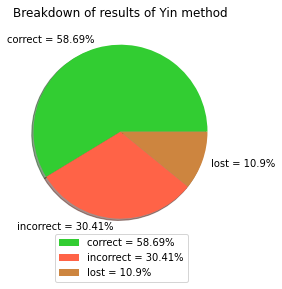

In [6]:
lost = total_samples - len(yin_data.values)
correct = yin_data["correct"].sum()
incorrect = total_samples - (correct + lost)

correct_percent = round((correct/total_samples) * 100, 2)
incorrect_percent = round((incorrect/total_samples) * 100, 2)
lost_percent = round((lost/total_samples)*100, 2)

print("correct {}% \t incorrect {}% \t lost {}%".format(correct_percent,
                                            incorrect_percent, lost_percent))

y = np.array([correct, incorrect, lost])

mylabels = ["correct = {}%".format(correct_percent),
            "incorrect = {}%".format(incorrect_percent),
            "lost = {}%".format(lost_percent)]
myexplode = [0.0, 0.0, 0]

plt.title("Breakdown of results of Yin method")
plt.pie(y, labels = mylabels, explode = myexplode, shadow=True, colors = ["limegreen","tomato","peru"])
plt.legend(bbox_to_anchor=(0.2,-0.08), loc="center left", borderaxespad=0)
#plt.savefig("yin_pie.svg", format='svg', dpi=3000)
plt.show()

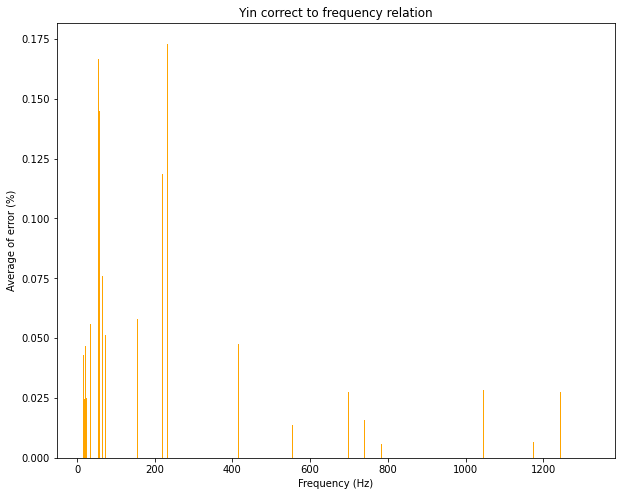

In [7]:
values = np.unique(yin_data["expected"].values)

x = values
y = []

for freq in values:
    freq_total = yin_data[yin_data["expected"] == freq]
    
    error_total = 0
    for i in freq_total.values:
        v1, v2 = closify(i[0], i[1])
        diff = abs(v1 - v2)/v1
        
        error_total += diff
        
    
    error_average = error_total/len(freq_total.values)
    y.append(error_average)

plt.figure(figsize=(10,8))
plt.bar(x[0:80], y[0:80], color="orange", )
plt.xlabel("Frequency (Hz)")
plt.ylabel("Average of error (%)")
plt.title("Yin correct to frequency relation")

plt.show()

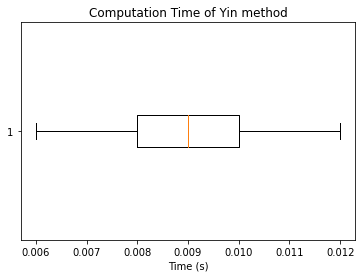

In [8]:
plt.boxplot(yin_data["time"], vert=False, showfliers=False)
plt.title("Computation Time of Yin method")
plt.xlabel("Time (s)")
plt.show()

<Figure size 432x288 with 0 Axes>

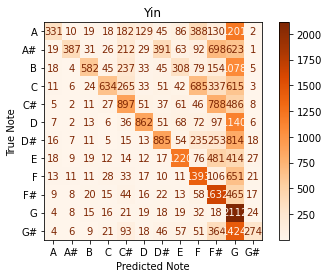

In [9]:
y_test, y_pred = [], []

for exp, pred in zip(yin_data["expected"], yin_data["estimated"]):
    # Compare note, excluding octaves (at [0] index)    
    y_test.append(frequency_to_note(exp)[0])
    y_pred.append(frequency_to_note(pred)[0])

plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = "Oranges")
plt.title("Yin")
plt.xlabel("Predicted Note")
plt.ylabel("True Note")
#plt.savefig("yin_confusion.svg", format='svg', dpi=3000)
plt.show()

## AMDF

In [10]:
# Obtain correct/incorrect prediction column
correct = []

for i, v in enumerate(amdf_data.values):
    
    if isCorrect(v[0], v[1]):
        correct.append(1)
    else:
        correct.append(0)

amdf_data["correct"] = correct

### Chart time:

correct 82.0% 	 incorrect 5.37% 	 lost 12.63%


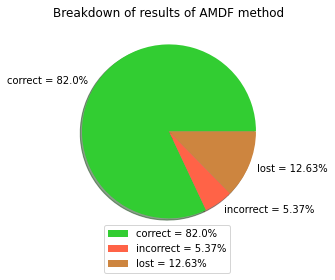

In [11]:
lost = total_samples - len(amdf_data.values)
correct = amdf_data["correct"].sum()
incorrect = total_samples - (correct + lost)

correct_percent = round((correct/total_samples) * 100, 2)
incorrect_percent = round((incorrect/total_samples) * 100, 2)
lost_percent = round((lost/total_samples)*100, 2)

print("correct {}% \t incorrect {}% \t lost {}%".format(correct_percent,
                                            incorrect_percent, lost_percent))

y = np.array([correct, incorrect, lost])

mylabels = ["correct = {}%".format(correct_percent),
            "incorrect = {}%".format(incorrect_percent),
            "lost = {}%".format(lost_percent)]
myexplode = [0, 0, 0]

plt.title("Breakdown of results of AMDF method")
plt.pie(y, labels = mylabels, explode = myexplode, shadow=True, colors = ["limegreen","tomato","peru"])
plt.legend(bbox_to_anchor=(0.2,-0.04), loc="center left", borderaxespad=0)
#plt.savefig("amdf_pie.svg", format='svg', dpi=3000)
plt.show()

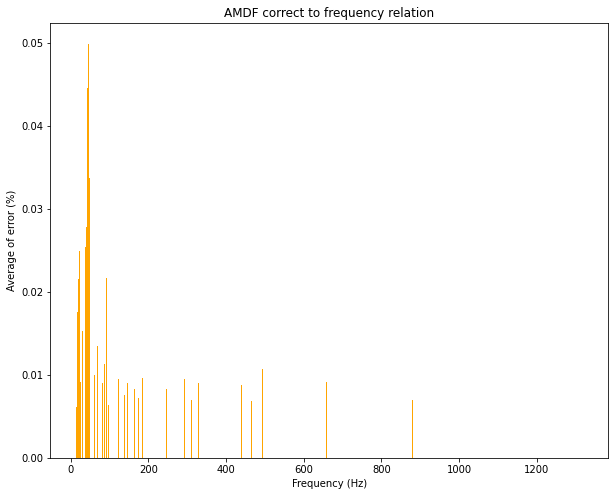

In [12]:
values = np.unique(amdf_data["expected"].values)

x = values
y = []

for freq in values:
    freq_total = amdf_data[amdf_data["expected"] == freq]
    
    error_total = 0
    for i in freq_total.values:
        v1, v2 = closify(i[0], i[1])
        diff = abs(v1 - v2)/v1
        
        error_total += diff
        
    error_average = error_total/len(freq_total.values)
    y.append(error_average)


plt.figure(figsize=(10,8))
plt.bar(x[0:80], y[0:80], color="orange", )
plt.xlabel("Frequency (Hz)")
plt.ylabel("Average of error (%)")
plt.title("AMDF correct to frequency relation")
plt.show()

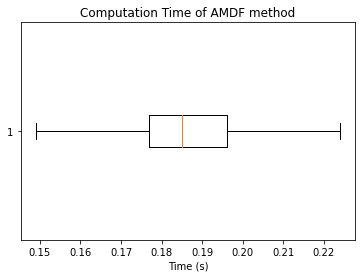

In [13]:
plt.boxplot(amdf_data["time"], vert=False, showfliers=False)
plt.title("Computation Time of AMDF method")
plt.xlabel("Time (s)")
plt.show()

Text(0, 0.5, 'True Note')

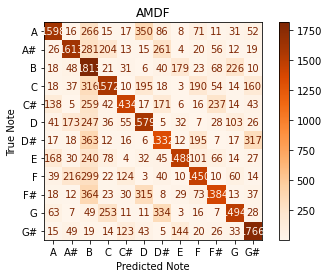

In [14]:
y_test, y_pred = [], []

for exp, pred in zip(amdf_data["expected"], amdf_data["estimated"]):
    # Compare note, excluding octaves (at [0] index)    
    y_test.append(frequency_to_note(exp)[0])
    y_pred.append(frequency_to_note(pred)[0])
    
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = "Oranges")
plt.title("AMDF")
plt.xlabel("Predicted Note")
plt.ylabel("True Note")
#plt.savefig("amdf_confusion.png")
#plt.savefig("amdf_confusion.svg", format='svg', dpi=3000)

## FFT:

In [15]:
# FFT data is slightly different
fft_data

,expected,actual,time
0,27.500000,220.0,0.008161
2,27.500000,110.0,0.000000
4,27.500000,328.0,0.000000
6,27.500000,218.0,0.006016
8,27.500000,110.0,0.008121
...,...,...,...
63520,7458.620184,730.0,0.002992
63522,7458.620184,329.0,0.003000
63524,7902.132820,428.0,0.001995
63526,8372.018090,187.0,0.002165


In [16]:
# Obtain correct/incorrect prediction column
correct = []

for i, v in enumerate(fft_data.values):
    if isCorrect(v[0], v[1]):
        correct.append(1)
    else:
        correct.append(0)

fft_data["correct"] = correct

### Graph Time:

correct 80.31% 	 incorrect 16.86% 	 lost 2.83%


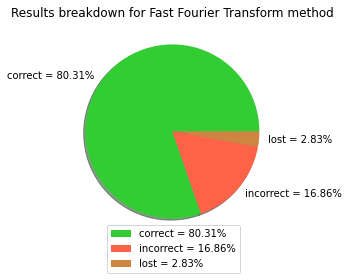

In [17]:
lost = total_samples - len(fft_data.values)
correct = fft_data["correct"].sum()
incorrect = total_samples - (correct + lost)

correct_percent = round((correct/total_samples) * 100, 2)
incorrect_percent = round((incorrect/total_samples) * 100, 2)
lost_percent = round((lost/total_samples)*100, 2)

print("correct {}% \t incorrect {}% \t lost {}%".format(correct_percent,
                                            incorrect_percent, lost_percent))

y = np.array([correct, incorrect, lost])

mylabels = ["correct = {}%".format(correct_percent),
            "incorrect = {}%".format(incorrect_percent),
            "lost = {}%".format(lost_percent)]
myexplode = [0, 0, 0]

plt.title("Results breakdown for Fast Fourier Transform method")
plt.pie(y, labels = mylabels, explode = myexplode, shadow=True, colors = ["limegreen","tomato","peru"])
plt.legend(bbox_to_anchor=(0.2,-0.04), loc="center left", borderaxespad=0)
#plt.savefig("fft_pie.svg", format='svg', dpi=3000)
plt.show()

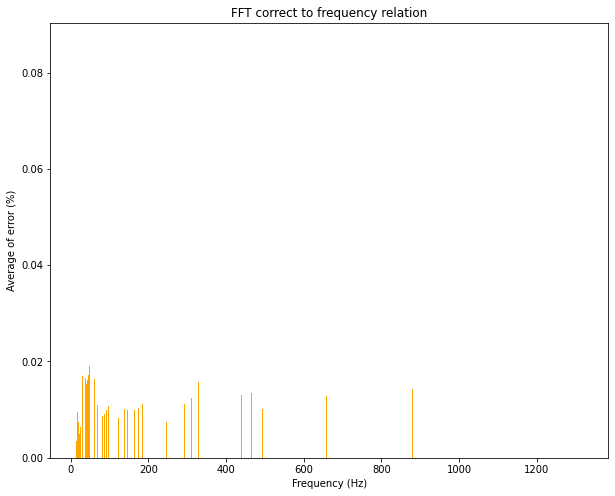

In [18]:
values = np.unique(fft_data["expected"].values)

x = values
y = []

for freq in values:
    freq_total = fft_data[fft_data["expected"] == freq]
    error_total = 0
    for i in freq_total.values:
        v1, v2 = closify(i[0], i[1])
        diff = abs(v1 - v2)/v1
        
        error_total += diff
    
    error_average = error_total/len(freq_total.values)
    y.append(error_average)


plt.figure(figsize=(10,8))
plt.bar(x[0:80], y[0:80], color="orange", )
plt.xlabel("Frequency (Hz)")
plt.ylabel("Average of error (%)")
plt.title("FFT correct to frequency relation")

plt.show()

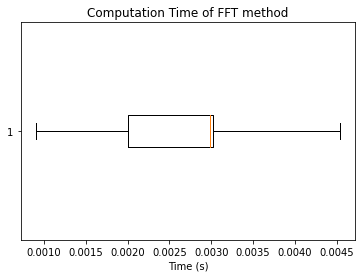

In [19]:
plt.boxplot(fft_data["time"], vert=False, showfliers=False)
plt.title("Computation Time of FFT method")
plt.xlabel("Time (s)")
plt.show()

Text(0, 0.5, 'True Note')

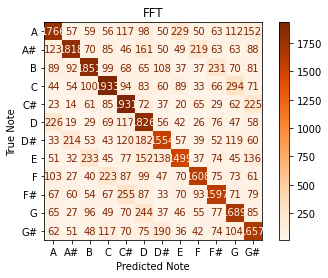

In [20]:
y_test, y_pred = [], []

for exp, pred in zip(fft_data["expected"], fft_data["actual"]):
    # We will just compare note, excluding octaves (at [0] index)    
    y_test.append(frequency_to_note(exp)[0])
    y_pred.append(frequency_to_note(pred)[0])
    
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = "Oranges")
plt.title("FFT")
plt.xlabel("Predicted Note")
plt.ylabel("True Note")
#plt.savefig("fft_confusion.svg", format='svg', dpi=3000)


## General Analysis:

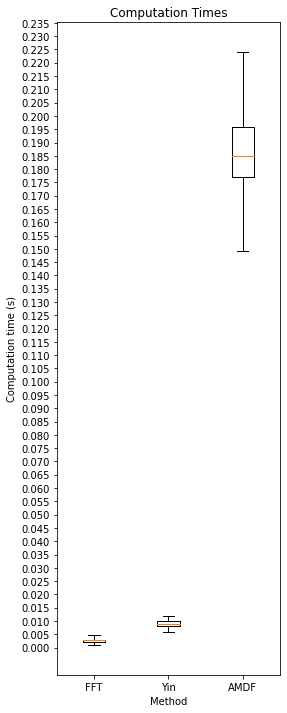

In [21]:
all_comp_times = [fft_data["time"], yin_data["time"], amdf_data["time"]]
labels = ["FFT", "Yin", "AMDF"]

fig, ax = plt.subplots(figsize=(4,12))
ax.boxplot(all_comp_times, vert=1, labels=labels, showfliers=False) # axs[1, 1].boxplot(data, 0, 'rs', 0)
ax.set_yticks(np.arange(0,0.24,0.005))

plt.ylabel("Computation time (s)")
plt.xlabel("Method")
plt.title("Computation Times")

#plt.savefig("computation_all.svg", format='svg', dpi=3000)

plt.show()